In [2]:
from typing import List

In [10]:
def get_requirements(file_path:str)->List[str]:
    '''
    Returns the requirements
    '''
    requirements = []
    with open(file_path) as file_obj:
        requirements = file_obj.readlines()
        
        for req in range(len(requirements)):
            requirements[req] = requirements[req].strip()
        
        if "-e ." in requirements:
            requirements.remove("-e .")

    return requirements

In [11]:
get_requirements("../requirements.txt")

['python==3.9',
 'selenium',
 'pandas',
 'numpy',
 'seaborn',
 'langchain-community',
 '']

In [1]:
from selenium import webdriver
from amazoncaptcha import AmazonCaptcha
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd

In [7]:
def scrape_products(keyword, num_products):

    try:
        path = Service(r"F:/Data Science/Projects/Ecommerce-Chatbot-Project/chromedriver.exe")
            
        # Initializing chrome_options
        chrome_options = Options()
            
        # opening the new chrome window with maximum size
        chrome_options.add_argument("--start-maximized")
            
        # timeout value for 10 seconds
        chrome_options.add_argument('--timeout=15')
            
        # scrape without a new Chrome window every time.
        # chrome_options.add_argument('headless')

        # initializing the driver
        driver = webdriver.Chrome(service=path, options=chrome_options)
            
        #driver.set_window_size(1120, 1000)

        # url of the website
        url = "https://www.amazon.in/"

        # connecting to the url
        driver.get(url)

        time.sleep(2)

        try:
            # captcha handling
            link = driver.find_element(By.XPATH, "//div[@class = 'a-row a-text-center']//img").get_attribute("src")    # <div class=a-row a-text-center>
            
            captcha = AmazonCaptcha.fromlink(link)
            captcha_value = AmazonCaptcha.solve(captcha)

            input_field = driver.find_element(By.ID, "captchacharacters")
            input_field.send_keys(captcha_value)

            continue_shopping = driver.find_element(By.CLASS_NAME, "a-button-text")
            continue_shopping.click()

        except NoSuchElementException:
            print("No captcha found")

        time.sleep(3)

        # search product
        search_tab = driver.find_element(By.XPATH, "/html/body/div[1]/header/div/div[1]/div[2]/div/form/div[2]/div[1]/div/input")
        search_tab.send_keys(keyword)
        search_button = driver.find_element(By.XPATH, "//input[@id='nav-search-submit-button']")
        search_button.click()
        time.sleep(3)

        data = []
        current_page = 1

        while len(data) < num_products:

            print(f"\nScraping page {current_page}")

            products = driver.find_elements(By.XPATH, "//div[@class='a-section a-spacing-base a-text-center']")
            print(f"Number of products found on page {current_page}: {len(products)}")

            # iterating through each products 
            for i in range(len(products)):
                print(f"Scraping product {i+1} on page {current_page}")
                product = products[i]   # get product element 

                try:
                    brand_name = product.find_element(By.XPATH,".//h2[@class='a-size-mini s-line-clamp-1']//span").text
                except:
                    brand_name = "na"
                
                try:   
                    product_name = product.find_element(By.XPATH, ".//h2[@class='a-size-base-plus a-spacing-none a-color-base a-text-normal']//span").text
                except:
                    product_name = "na"
                    
                try:
                    # .text doesn't work because of unknown factors like css, therefore we use 'textContent'
                    rating_element = product.find_element(By.XPATH, ".//i[@data-cy='reviews-ratings-slot']//span")
                    rating = rating_element.get_attribute('textContent')
                except:
                    rating = "na"

                try: 
                    rating_count = product.find_element(By.XPATH, ".//span[@class='a-size-base s-underline-text']").text
                except:
                    rating_count = "na"

                try: 
                    selling_price_element = product.find_element(By.XPATH, ".//span[@class='a-price']//span[@class='a-offscreen']")
                    selling_price = selling_price_element.get_attribute('textContent')
                except:
                    selling_price = "na"
                
                try: 
                    mrp = product.find_element(By.XPATH, ".//span[@class='a-price a-text-price']//span[@aria-hidden='true']").text
                except:
                    mrp = "na"

                try: 
                    offer = product.find_element(By.XPATH, ".//div[@class='a-row']//span[contains(text(), '%')]").text
                except:
                    offer = "na"
                
                # try:
                #     delivery_price = driver.find_element(By.XPATH, "/html/body/div[1]/div[1]/div[1]/div[1]/div/span[1]/div[1]/div[3]/div/div/div/div/span/div/div/div[2]/div[5]/div/div[2]/span/span[1]")
                # except:
                #     delivery_price = "na"


                data.append({"Brand Name": brand_name,
                            "Product Name": product_name,
                            "Rating": rating,
                            "Rating Count": rating_count,
                            "Selling Price": selling_price,
                            "MRP": mrp,
                            "Offer": offer})
                            #"Delivery Price: ", delivery_price})
            
                # Break out of the loop if the desired number of products is reached
                if len(data) == num_products:
                    #break
                    df = pd.DataFrame(data)
                    return df  # Immediately exits the entire function if condition is met

            # Click the "Next" button to go to the next page if the desired number of products isn't reached
            time.sleep(3)
            try:
                next_button = driver.find_element(By.XPATH, "//a[@class='s-pagination-item s-pagination-next s-pagination-button s-pagination-button-accessibility s-pagination-separator']")
                next_button.click()
                current_page += 1
                time.sleep(3)  
            except NoSuchElementException:
                print("No next page found. Ending scrape.")
                break
                
        df = pd.DataFrame(data)
        return df 
    
    finally:
        driver.quit()
    


In [9]:
scrape_products("Mens formal shirts", 50)


Scraping page 1
Number of products found on page 1: 70
Scraping product 1 on page 1
Scraping product 2 on page 1
Scraping product 3 on page 1
Scraping product 4 on page 1
Scraping product 5 on page 1
Scraping product 6 on page 1
Scraping product 7 on page 1
Scraping product 8 on page 1
Scraping product 9 on page 1
Scraping product 10 on page 1
Scraping product 11 on page 1
Scraping product 12 on page 1
Scraping product 13 on page 1
Scraping product 14 on page 1
Scraping product 15 on page 1
Scraping product 16 on page 1
Scraping product 17 on page 1
Scraping product 18 on page 1
Scraping product 19 on page 1
Scraping product 20 on page 1
Scraping product 21 on page 1
Scraping product 22 on page 1
Scraping product 23 on page 1
Scraping product 24 on page 1
Scraping product 25 on page 1
Scraping product 26 on page 1
Scraping product 27 on page 1
Scraping product 28 on page 1
Scraping product 29 on page 1
Scraping product 30 on page 1
Scraping product 31 on page 1
Scraping product 32 on 

,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
0,Symbol Premium,Men's Wrinkle-Resistant Regular Fit Cotton For...,4.0 out of 5 stars,497,"₹1,699","₹2,599",(35% off)
1,Symbol Premium,Men's Cotton Non-Iron Formal Shirt (Regular Fi...,3.7 out of 5 stars,69,"₹1,899","₹3,999",(53% off)
2,Amazon Brand - Symbol,Men's Solid Cotton Formal Shirt | Plain | Full...,3.9 out of 5 stars,"8,650",₹599,"₹1,799",(67% off)
3,Amazon Brand - Symbol,Men's Solid Cotton Rich Formal Shirt | Plain |...,3.8 out of 5 stars,"10,351",₹549,"₹1,699",(68% off)
4,Generic,Stylish Men’s Luster Cotton Blend Shirt - Comf...,3.4 out of 5 stars,8,₹499,₹999,(50% off)
5,Peter England,Men's Everday Regular Fit Solid Shirt | Cotton...,3.9 out of 5 stars,"1,002",₹789,"₹1,399",(44% off)
6,Pinkmint,Mens Long Sleeve Button Down Shirt for Men Col...,3.7 out of 5 stars,732,₹379,"₹1,999",(81% off)
7,Peter England,Premium Wonder Fabric Slim Fit Full Sleeve Str...,4.1 out of 5 stars,47,"₹1,009","₹1,799",(44% off)
8,Generic,"Solid Full Sleeves Shirt, Wrinkle Free Mens Sh...",3.2 out of 5 stars,4,₹499,₹999,(50% off)
9,Arrow,Men's Regular Fit Shirt,4.0 out of 5 stars,333,"₹1,039","₹1,999",(48% off)


In [4]:
path = Service(r"F:/Data Science/Projects/Ecommerce-Chatbot-Project/chromedriver.exe")
        
# Initializing chrome_options
chrome_options = Options()
        
# opening the new chrome window with maximum size
chrome_options.add_argument("--start-maximized")
        
# timeout value for 10 seconds
chrome_options.add_argument('--timeout=15')
        
# Uncomment the line below if you'd like to scrape without a new Chrome window every time.
# chrome_options.add_argument('headless')

# initializing the driver
driver = webdriver.Chrome(service=path, options=chrome_options)
wait = WebDriverWait(driver, 10)        
#driver.set_window_size(1120, 1000)

# url of the website
url = "https://www.amazon.in/"

# connecting to the url
driver.get(url)

# wait time of 3 seconds for the website to load
time.sleep(3)

try:
    # bypass captcha
    link = driver.find_element(By.XPATH, "//div[@class = 'a-row a-text-center']//img").get_attribute("src")
    print("Captcha found bypassing it...")
    
    captcha = AmazonCaptcha.fromlink(link)
    captcha_value = AmazonCaptcha.solve(captcha)

    input_field = driver.find_element(By.ID, "captchacharacters")
    input_field.send_keys(captcha_value)

    continue_shopping = driver.find_element(By.CLASS_NAME, "a-button-text")
    continue_shopping.click()

except NoSuchElementException:
    print("No captcha found")

time.sleep(2)

# finding the search tab and entering search item 
search_tab = driver.find_element(By.XPATH, "/html/body/div[1]/header/div/div[1]/div[2]/div/form/div[2]/div[1]/div/input")
search_tab.send_keys("Mens formal shirt")

# clicking "ENTER" key to initiate search
#search_tab.send_keys(Keys.ENTER)

# finding the search(submit) button and clicking it
#search_button = driver.find_element(By.XPATH, "/html/body/div[1]/header/div/div[1]/div[2]/div/form/div[3]/div/span/input")
search_button = driver.find_element(By.XPATH, "//input[@id='nav-search-submit-button']")
search_button.click()

time.sleep(5)

# while True:
#     products = driver.find_elements(By.XPATH, "//div[@class='a-section a-spacing-base a-text-center'][1]")
#     print("Number of products found on page one: ", len(products))

# try:
#          #price = driver.find_element(By.CSS_SELECTOR, "a.a-link-normal span.a-offscreen").text 
#          price = driver.find_element(By.XPATH, "//span[@class='a-price']//span[@class='a-offscreen']").text      
# except NoSuchElementException:
#          price = "na"

print("hello")

#price = driver.find_element(By.XPATH, "//div[@class='a-row a-size-base a-color-base']//div[@class='a-row']//span[@class='a-price']//span[@class='a-offscreen']").text 
#price = driver.find_element(By.XPATH, "/html/body/div[1]/div[1]/div[1]/div[1]/div/span[1]/div[1]/div[3]/div/div/div/div/span/div/div/div[2]/div[4]/div[1]/div[1]/a/span/span[1]").text
#price = driver.find_element(By.XPATH, "//span[@class='a-price']//span[@class='a-offscreen']")
#mrp = driver.find_element(By.XPATH, "//span[@class='a-price a-text-price']//span[@class='a-offscreen']")
offer = driver.find_element(By.XPATH, "//div[@class='a-row']//span[contains(text(), '%')]").text
time.sleep(5) 
print(offer)
#print(mrp.get_attribute('textContent'))
print("hello")
    

time.sleep(5)
next_button = driver.find_element(By.XPATH, "//a[@class='s-pagination-item s-pagination-next s-pagination-button s-pagination-button-accessibility s-pagination-separator']")

time.sleep(5)
next_button.click()
# print(f"Number of prices found: {len(prices)}")
# if prices:
#     print("Price:", prices[0].text)
# else:
#     print("No price elements found.")




# prices = wait.until(EC.presence_of_all_elements_located(
#      (By.XPATH, "//span[@class='a-price']//span[@class='a-offscreen']")
#  ))

# try:
# #     print("Element found: ", prices[1].is_displayed())  # Check if element is visible
# #     print("Text content: ", prices[1].get_attribute('textContent'))  # Try getting text this way
# #     print("Inner HTML: ", prices[1].get_attribute('innerHTML'))  # See what's inside the element
#      print("Direct text: ", prices[1].text)  # Original attempt
# except Exception as e:
#     print(f"Error: {e}")

Captcha found bypassing it...
hello
(31% off)
hello


In [1]:
import os 
os.getcwd()

'f:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Rough'

In [2]:
os.path.dirname(os.getcwd())

'f:\\Data Science\\Projects\\Ecommerce-Chatbot-Project'

In [3]:
from src.logger import logging

logging.info("Hello")

In [4]:
from src.logger import logging

In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path="../Data/data.csv")

data = loader.load()

print(data)

[Document(metadata={'source': '../Data/data.csv', 'row': 0}, page_content="Brand Name: Symbol Premium\nProduct Name: Men's Wrinkle-Resistant Regular Fit Cotton Formal Shirt\nRating: 4.0 out of 5 stars\nRating Count: 499\nSelling Price: ₹1,699\nMRP: ₹2,599\nOffer: (35% off)"), Document(metadata={'source': '../Data/data.csv', 'row': 1}, page_content="Brand Name: Symbol Premium\nProduct Name: Men's Cotton Non-Iron Formal Shirt (Regular Fit | Solid)\nRating: 3.7 out of 5 stars\nRating Count: 70\nSelling Price: ₹1,899\nMRP: ₹3,999\nOffer: (53% off)"), Document(metadata={'source': '../Data/data.csv', 'row': 2}, page_content="Brand Name: Amazon Brand - Symbol\nProduct Name: Men's Solid Cotton Rich Formal Shirt | Plain | Full Sleeve-Regular Fit (Available in Plus Size)\nRating: 3.8 out of 5 stars\nRating Count: 10,355\nSelling Price: ₹549\nMRP: ₹1,699\nOffer: (68% off)"), Document(metadata={'source': '../Data/data.csv', 'row': 3}, page_content="Brand Name: Amazon Brand - Symbol\nProduct Name: 

In [8]:
import pandas as pd 
df = pd.read_csv("../Data/data.csv")
df.columns

Index(['Brand Name', 'Product Name', 'Rating', 'Rating Count', 'Selling Price',
       'MRP', 'Offer'],
      dtype='object')

In [9]:
df.head()

,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
0,Symbol Premium,Men's Wrinkle-Resistant Regular Fit Cotton For...,4.0 out of 5 stars,499,"₹1,699","₹2,599",(35% off)
1,Symbol Premium,Men's Cotton Non-Iron Formal Shirt (Regular Fi...,3.7 out of 5 stars,70,"₹1,899","₹3,999",(53% off)
2,Amazon Brand - Symbol,Men's Solid Cotton Rich Formal Shirt | Plain |...,3.8 out of 5 stars,"10,355",₹549,"₹1,699",(68% off)
3,Amazon Brand - Symbol,Men's Solid Cotton Formal Shirt | Plain | Full...,3.9 out of 5 stars,"8,650",₹599,"₹1,799",(67% off)
4,Generic,Stylish Men’s Luster Cotton Blend Shirt - Comf...,3.4 out of 5 stars,8,₹499,₹999,(50% off)


In [11]:
df.isna().sum()

Brand Name       0
Product Name     0
Rating           0
Rating Count     0
Selling Price    0
MRP              0
Offer            0
dtype: int64

In [12]:
# Function to format each row into a text chunk
def format_product(row):
    return (f"Brand: {row['Brand Name']}, Product: {row['Product Name']}, "
            f"Rating: {row['Rating']} ({row['Rating Count']} reviews), "
            f"Selling Price: {row['Selling Price']} "
            f"(MRP: {row['MRP']}, Offer: {row['Offer']})")

# Apply function to all rows
df["text_chunk"] = df.apply(format_product, axis=1)

# Save processed data for FAISS indexing
df[["text_chunk"]].to_csv("processed_data.csv", index=False)

In [2]:
import pandas as pd
df_processed = pd.read_csv('processed_data.csv')



In [3]:
df_processed.head()

,text_chunk
0,"Brand: Symbol Premium, Product: Men's Wrinkle-..."
1,"Brand: Symbol Premium, Product: Men's Cotton N..."
2,"Brand: Amazon Brand - Symbol, Product: Men's S..."
3,"Brand: Amazon Brand - Symbol, Product: Men's S..."
4,"Brand: Generic, Product: Stylish Men’s Luster ..."


In [1]:
from langchain_community.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path='../Data/data.csv',
                   csv_args={'delimiter': ',',
                             'quotechar': '"',
                            'fieldnames': ['Brand Name', 'Product Name', 'Rating', 'Rating Count', 'Selling Price', 'MRP', 'Offer'] })
                            
docs = loader.load()

In [2]:
docs

[Document(metadata={'source': '../Data/data.csv', 'row': 0}, page_content='Brand Name: Brand Name\nProduct Name: Product Name\nRating: Rating\nRating Count: Rating Count\nSelling Price: Selling Price\nMRP: MRP\nOffer: Offer'),
 Document(metadata={'source': '../Data/data.csv', 'row': 1}, page_content="Brand Name: Symbol Premium\nProduct Name: Men's Wrinkle-Resistant Regular Fit Cotton Formal Shirt\nRating: 4.0 out of 5 stars\nRating Count: 499\nSelling Price: ₹1,699\nMRP: ₹2,599\nOffer: (35% off)"),
 Document(metadata={'source': '../Data/data.csv', 'row': 2}, page_content="Brand Name: Symbol Premium\nProduct Name: Men's Cotton Non-Iron Formal Shirt (Regular Fit | Solid)\nRating: 3.7 out of 5 stars\nRating Count: 70\nSelling Price: ₹1,899\nMRP: ₹3,999\nOffer: (53% off)"),
 Document(metadata={'source': '../Data/data.csv', 'row': 3}, page_content="Brand Name: Amazon Brand - Symbol\nProduct Name: Men's Solid Cotton Rich Formal Shirt | Plain | Full Sleeve-Regular Fit (Available in Plus Size)

In [6]:
docs?

Type:        list
String form: [Document(metadata={'source': '../Data/data.csv', 'row': 0}, page_content='Brand Name: Brand Name <...> ing: 3.7 out of 5 stars\nRating Count: 709\nSelling Price: ₹599\nMRP: ₹3,199\nOffer: (81% off)")]
Length:      431
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

In [7]:
text = [d.page_content for d in docs]

In [11]:
text[1]

"Brand Name: Symbol Premium\nProduct Name: Men's Wrinkle-Resistant Regular Fit Cotton Formal Shirt\nRating: 4.0 out of 5 stars\nRating Count: 499\nSelling Price: ₹1,699\nMRP: ₹2,599\nOffer: (35% off)"

import os 
from dotenv import load_dotenv
load_dotenv()

from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

client = NVIDIAEmbeddings(
  model="nvidia/nv-embedqa-mistral-7b-v2", 
  api_key=os.getenv("NVIDIA_API_KEY"),
  truncate="NONE", 
  )

embedding = client.embed_documents(text)
print(embedding)


In [1]:
from langchain_community.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path='../Data/data_watches.csv')
data = loader.load()

In [3]:
from langchain_community.document_loaders import DirectoryLoader, CSVLoader
loader = DirectoryLoader(path=r"F:\Data Science\Projects\Ecommerce-Chatbot-Project\Data",
                        glob="*.csv",
                        loader_cls=CSVLoader,
                        loader_kwargs={'csv_args': {'delimiter': ',', 'quotechar': '"'}})
docs = loader.load()

In [4]:
len(docs)

1281

In [13]:
docs

[Document(metadata={'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_sarees.csv', 'row': 0}, page_content="Brand Name: SGF11\nProduct Name: Women's Kanjivaram Pure Soft Silk Handloom Saree Pure Golden Zari With Blouse Piece\nRating: 4.2 out of 5 stars\nRating Count: 769\nSelling Price: ₹1,499\nMRP: ₹5,999\nOffer: (75% off)"),
 Document(metadata={'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_sarees.csv', 'row': 1}, page_content="Brand Name: SGF11\nProduct Name: Women's Kanjivaram Woven Soft Silk Saree With Blouse Piece\nRating: 4.0 out of 5 stars\nRating Count: 1,948\nSelling Price: ₹1,699\nMRP: ₹8,999\nOffer: (81% off)"),
 Document(metadata={'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_sarees.csv', 'row': 2}, page_content='Brand Name: Generic\nProduct Name: Traditional Art cotton Saree with Elephant and Peacock Print zari Border, Green and Gold, with Matching Blouse Piece with tyedye daying\nRati

In [3]:
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

f:\Data Science\Projects\Ecommerce-Chatbot-Project\envi\lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [22]:
pc = Pinecone(api_key=)
index_name = "fun"
pc.create_index(name=index_name,
                 dimension = 4096,
                 metric="cosine",
                 spec=ServerlessSpec(cloud="aws",region="us-east-1"))




In [19]:
index 

In [5]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embed = NVIDIAEmbeddings(
  model="nvidia/nv-embedqa-mistral-7b-v2", 
  api_key=os.getenv("NVIDIA_API_KEY"), 
  truncate="NONE", 
  )


In [26]:
vector_store = PineconeVectorStore.from_documents(documents=docs,
                                                              index_name=index_name, 
                                                              embedding = embed)

In [6]:
docsearch = PineconeVectorStore.from_existing_index(
    index_name="ecommerce-chatbot-project",
    embedding=embed)

In [16]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

In [17]:
import os 
from dotenv import load_dotenv
load_dotenv()

llm = ChatGroq(temperature=0.6,
                           model_name="llama-3.3-70b-versatile",
                           groq_api_key=os.getenv("GROQ_API_KEY"),
                           max_tokens=4096)


In [23]:
retriever = docsearch.as_retriever()

In [18]:
system_prompt = """You are a knowledgeable and friendly fashion consultant for a high-end e-commerce store. 
            Your store specializes in:
            - Men's clothing
            - Women's clothing
            - Watches for men 

            Guidelines for interaction:
            1. Be warm and professional in your responses
            2. Provide specific product recommendations based on the context
            3. Include relevant details about materials, styles, and pricing when available
            4. If asked about products we don't carry, politely explain our product range
            6. Always prioritize customer satisfaction while being honest about product availability

            Current context about our products and inventory:
            {context}
            
            Remember: Only provide information based on the context above. If certain details aren't available, 
            be honest and offer to help the customer find relevant alternatives or suggest contacting customer service for more specific information."""
        
prompt = ChatPromptTemplate.from_messages([("system", system_prompt),
                                            #essagesPlaceholder(variable_name="chat_history"),  # For maintaining conversation history
                                            ("human", "{input}")]) 

In [19]:
doc_chain = create_stuff_documents_chain(llm=llm, 
                                        prompt=prompt,
                                        output_parser=StrOutputParser(),
                                        document_variable_name="context")
            

retrieval_chain = create_retrieval_chain(retriever=retriever, 
                                                     combine_docs_chain=doc_chain)

In [20]:
retrieval_chain.invoke({"input": "what do you do?"})

{'input': 'what do you do?',
 'context': [Document(id='d7321768-3623-4c05-a4df-30d8fd7bc4c4', metadata={'row': 392.0, 'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_watches.csv'}, page_content="Brand Name: SKMEI\nProduct Name: Men's Watch New Wheels Rolling Creative Fashion Che Youhui League Fans Butterfly Double Snap Gift Wristwatch - 1787\nRating: 4.2 out of 5 stars\nRating Count: 1,055\nSelling Price: ₹1,799\nMRP: ₹6,999\nOffer: (74% off)"),
  Document(id='ec4d4f30-155b-4dea-b4a4-820ef2ff4eab', metadata={'row': 215.0, 'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_watches.csv'}, page_content="Brand Name: SKMEI\nProduct Name: Men's Watch New Wheels Rolling Creative Fashion Che Youhui League Fans Butterfly Double Snap Gift Wristwatch - 1787\nRating: 4.2 out of 5 stars\nRating Count: 1,055\nSelling Price: ₹1,799\nMRP: ₹6,999\nOffer: (74% off)"),
  Document(id='66f62082-5160-41b6-b5fc-26443f54be3f', metadata={'row': 139.0, 'sou

In [1]:
from src.utils.chatbot_utils import Utils

f:\Data Science\Projects\Ecommerce-Chatbot-Project\envi\lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [11]:
utils = Utils()
chatbot = utils.build_chatbot()

In [3]:
chatbot.invoke({"input": "What do you do?"})

{'input': 'What do you do?',
 'context': [],
 'answer': "I'm a fashion consultant for a high-end e-commerce store. My role is to provide personalized styling advice and recommendations to customers looking for men's and women's clothing, as well as watches for men. I'm here to help you find the perfect piece to elevate your wardrobe, whether it's a special occasion or everyday wear. How can I assist you today?"}

In [4]:
chatbot.invoke({"input": "I need a branded high quality formal shirt, the fabric must be cotton and I also need a watch that suits the shirt. "})

{'input': 'I need a branded high quality formal shirt, the fabric must be cotton and I also need a watch that suits the shirt. ',
 'context': [],
 'answer': "I'd be delighted to help you find a high-quality formal shirt made of cotton, along with a complementary watch.\n\nFor the shirt, I recommend our luxurious cotton dress shirts from renowned brands such as Tom Ford or Burberry. We have a range of styles to choose from, including slim-fit and classic-fit options. One of our top picks is the Tom Ford Slim-Fit Cotton Dress Shirt, made from 100% cotton and featuring a subtle texture and elegant design. This shirt is priced at $495 and is available in a variety of colors, including white, light blue, and pink.\n\nTo complement your new shirt, I suggest pairing it with a sleek and sophisticated watch. Our collection of men's watches features top brands like Omega and TAG Heuer. The Omega Seamaster Aqua Terra Watch, priced at $5,700, would be an excellent choice to pair with your formal s

In [6]:

vector_store = utils.load_vectorstore(utils.create_embeddings())
# Check what's in your vector store
results = vector_store.similarity_search("cotton shirt", k=3)
for doc in results:
    print(doc.page_content)

Brand Name: DAMENSCH
Product Name: Constant Cotton Thermoregulating Pique Full Shirts
Rating: 4.3 out of 5 stars
Rating Count: 244
Selling Price: ₹1,558
MRP: ₹1,799
Offer: (13% off)
Brand Name: DAMENSCH
Product Name: Constant Cotton Thermoregulating Pique Full Shirts
Rating: 4.3 out of 5 stars
Rating Count: 244
Selling Price: ₹1,559
MRP: ₹1,799
Offer: (13% off)
Brand Name: DAMENSCH
Product Name: Constant Cotton Thermoregulating Pique Full Shirts
Rating: 4.3 out of 5 stars
Rating Count: 244
Selling Price: ₹1,488
MRP: ₹1,799
Offer: (17% off)


In [9]:
def debug_retrieval(chain, query):
    """Helper method to see what documents are being retrieved"""
    response = chain.invoke({
        "input": query
    })
    
    print("Retrieved Documents:")
    if response['context']:
        for i, doc in enumerate(response['context'], 1):
            print(f"\nDocument {i}:")
            print(doc.page_content)
    else:
        print("No documents retrieved!")
    
    print("\nModel Response:")
    print(response['answer'])
    
    return response

In [12]:
query = "I need a cotton shirt under 500 rupees"
debug_retrieval(chatbot, query)

Retrieved Documents:

Document 1:
Brand Name: RAMRAJ COTTON
Product Name: Solid Full Sleeve Regular Collor and Regular fit Shirt for Men
Rating: 4.0 out of 5 stars
Rating Count: 184
Selling Price: ₹925
MRP: na
Offer: na

Document 2:
Brand Name: Peter England
Product Name: Men's Everday Regular Fit Solid Shirt | Cotton Rich | 5-Pin Pocketing
Rating: 4.2 out of 5 stars
Rating Count: 31
Selling Price: ₹789
MRP: ₹1,399
Offer: (44% off)

Document 3:
Brand Name: Peter England
Product Name: Men's Everday Regular Fit Solid Shirt | Cotton Rich | 5-Pin Pocketing
Rating: 3.9 out of 5 stars
Rating Count: 1,003
Selling Price: ₹789
MRP: ₹1,399
Offer: (44% off)

Document 4:
Brand Name: Cantabil
Product Name: Cotton Blend Solid Full Sleeve Regular Fit Formal Shirt for Men with Pocket | Cotton Blend Formal Shirt for Men | Formal Wear Shirts for Men (P_MSHF00366)
Rating: 5.0 out of 5 stars
Rating Count: 1
Selling Price: ₹990
MRP: ₹2,199
Offer: (55% off)

Model Response:
I'm happy to help you find a cott

{'input': 'I need a cotton shirt under 500 rupees',
 'context': [Document(id='00d5854c-349a-4c6d-91b5-d412e10a209e', metadata={'row': 178.0, 'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_shirts.csv'}, page_content='Brand Name: RAMRAJ COTTON\nProduct Name: Solid Full Sleeve Regular Collor and Regular fit Shirt for Men\nRating: 4.0 out of 5 stars\nRating Count: 184\nSelling Price: ₹925\nMRP: na\nOffer: na'),
  Document(id='70001043-a8b5-4224-b155-97a5963f9df9', metadata={'row': 35.0, 'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_shirts.csv'}, page_content="Brand Name: Peter England\nProduct Name: Men's Everday Regular Fit Solid Shirt | Cotton Rich | 5-Pin Pocketing\nRating: 4.2 out of 5 stars\nRating Count: 31\nSelling Price: ₹789\nMRP: ₹1,399\nOffer: (44% off)"),
  Document(id='e84c8428-41ba-4bbf-914e-fdec4bc8aecb', metadata={'row': 5.0, 'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_shirts.csv'}

In [17]:
import pandas as pd
import glob

# Load all CSV files and combine them into a single DataFrame
file_paths = glob.glob("../Data/*.csv")
combined_df = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)

print(combined_df.head())  # Prints first few rows


       Brand Name                                       Product Name  \
0           SGF11  Women's Kanjivaram Pure Soft Silk Handloom Sar...   
1           SGF11  Women's Kanjivaram Woven Soft Silk Saree With ...   
2         Generic  Traditional Art cotton Saree with Elephant and...   
3          Vintro  Women's bollywood japani satin digital print s...   
4  C J Enterprise  Women's Kanjivaram Art Silk Saree Soft Banaras...   

               Rating Rating Count Selling Price     MRP      Offer  
0  4.2 out of 5 stars          769        ₹1,499  ₹5,999  (75% off)  
1  4.0 out of 5 stars        1,948        ₹1,699  ₹8,999  (81% off)  
2                  na           na          ₹990  ₹1,600  (38% off)  
3                  na           na        ₹1,379  ₹4,599  (70% off)  
4  4.1 out of 5 stars        1,418          ₹499    ₹999  (50% off)  


In [18]:
len(combined_df)

1281

In [20]:
dfs = []
for file in file_paths:
    df = pd.read_csv(file)
    dfs.append(df) 

In [22]:
df_all = pd.concat(dfs)

In [23]:
len(df_all)

1281

In [24]:
na = df_all.contains()

Brand Name       0
Product Name     0
Rating           0
Rating Count     0
Selling Price    0
MRP              0
Offer            0
dtype: int64

In [42]:
df_filtered1 = df_all[df_all.applymap(lambda x: str(x).strip().lower() == "na").any(axis=1)]


C:\Users\Gokul\AppData\Local\Temp\ipykernel_63636\2403101919.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_filtered1 = df_all[df_all.applymap(lambda x: str(x).strip().lower() == "na").any(axis=1)]


In [43]:
len(df_filtered1)

203

In [44]:
df_filtered1.head(203)

,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
2,Generic,Traditional Art cotton Saree with Elephant and...,na,na,₹990,"₹1,600",(38% off)
3,Vintro,Women's bollywood japani satin digital print s...,na,na,"₹1,379","₹4,599",(70% off)
9,AYYAPPASILK,"Women's Mysore Silk Saree Handwoven, Lightweig...",na,na,₹999,"₹1,699",(41% off)
21,Garden Vareli,Floral Print Georgette Saree,na,na,₹999,"₹1,699",(41% off)
55,Generic,Siroski Fancy Designer Saree,na,na,₹870,"₹1,740",(50% off)
58,Garden Vareli,Elegant Lace Border Lintus Saree with Unstitch...,na,na,"₹1,199","₹2,399",(50% off)
84,Generic,Graceful and Stylish Saree Grace for Every Spe...,na,na,"₹5,499","₹6,999",(21% off)
85,PRITIsree,Sambalpuri Handloom Saree Women's Cotton Saree...,na,na,"₹3,998","₹1,080.54",na
86,Garden Vareli,Abstract Print Viscose Saree With Unstitched B...,na,na,₹999,"₹1,999",(50% off)
87,Shiv Textiles,Womens Saree For Women,na,na,₹299,₹499,(40% off)


In [53]:
na_counts = df_all.applymap(lambda x: str(x).strip().lower() == "na").sum()
print(na_counts)


Brand Name         0
Product Name       0
Rating           137
Rating Count     137
Selling Price      1
MRP               67
Offer             72
dtype: int64


C:\Users\Gokul\AppData\Local\Temp\ipykernel_63636\1328025383.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  na_counts = df_all.applymap(lambda x: str(x).strip().lower() == "na").sum()


In [54]:
df_rough = df_filtered1.replace("na", pd.NA)

In [57]:
df_rough.loc[313]

,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
313,Soch,Womens Floral Woven Design Art Silk Saree,5.0 out of 5 stars,2,"₹1,998",<NA>,<NA>
313,Sonata,Beyond Gold Analog Black Dial Men's Watch-NN77...,4.3 out of 5 stars,419,"₹2,149",<NA>,<NA>


In [58]:
# Convert "na" values to actual NaN
df_rough = df_filtered1.replace("na", pd.NA)

# Separate numerical and categorical columns
num_cols = df_rough.select_dtypes(include=['number']).columns
cat_cols = df_rough.select_dtypes(include=['object']).columns

# Fill missing values
df_rough[num_cols] = df_all[num_cols].apply(lambda col: col.fillna(col.mean()))
df_rough[cat_cols] = df_all[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Display cleaned DataFrame
print(df_rough)


          Brand Name                                       Product Name  \
2            Generic  Traditional Art cotton Saree with Elephant and...   
3             Vintro  Women's bollywood japani satin digital print s...   
9        AYYAPPASILK  Women's Mysore Silk Saree Handwoven, Lightweig...   
21     Garden Vareli                       Floral Print Georgette Saree   
55           Generic                       Siroski Fancy Designer Saree   
58     Garden Vareli  Elegant Lace Border Lintus Saree with Unstitch...   
84           Generic  Graceful and Stylish Saree Grace for Every Spe...   
85         PRITIsree  Sambalpuri Handloom Saree Women's Cotton Saree...   
86     Garden Vareli  Abstract Print Viscose Saree With Unstitched B...   
87     Shiv Textiles                             Womens Saree For Women   
142             Soch  Womens Fuchsia Silk Blend Embroidered Saree Wi...   
144    Shiv Textiles                             Womens Saree For Women   
147    Shiv Textiles     

In [59]:
df_rough.head(20)

,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
2,Generic,Traditional Art cotton Saree with Elephant and...,4.3 out of 5 stars,5,₹990,"₹1,600",(38% off)
3,Vintro,Women's bollywood japani satin digital print s...,4.3 out of 5 stars,5,"₹1,379","₹4,599",(70% off)
9,AYYAPPASILK,"Women's Mysore Silk Saree Handwoven, Lightweig...",4.3 out of 5 stars,5,₹999,"₹1,699",(41% off)
21,Garden Vareli,Floral Print Georgette Saree,4.3 out of 5 stars,5,₹999,"₹1,699",(41% off)
55,Generic,Siroski Fancy Designer Saree,4.3 out of 5 stars,5,₹870,"₹1,740",(50% off)
58,Garden Vareli,Elegant Lace Border Lintus Saree with Unstitch...,4.3 out of 5 stars,5,"₹1,199","₹2,399",(50% off)
84,Generic,Graceful and Stylish Saree Grace for Every Spe...,4.3 out of 5 stars,5,"₹5,499","₹6,999",(21% off)
85,PRITIsree,Sambalpuri Handloom Saree Women's Cotton Saree...,4.3 out of 5 stars,5,"₹3,998","₹1,080.54",(40% off)
86,Garden Vareli,Abstract Print Viscose Saree With Unstitched B...,4.3 out of 5 stars,5,₹999,"₹1,999",(50% off)
87,Shiv Textiles,Womens Saree For Women,4.3 out of 5 stars,5,₹299,₹499,(40% off)


In [35]:
import sys
import os

import pandas as pd
from pandas import DataFrame  
import numpy as np 
import glob

from src.utils.logger import logging 
from src.utils.exception import Custom_exception


class DataCleaning:
    """
    Remove nan values from the data 
    """

    def __init__(self):
        pass

    def load_data(self, file_path):
        try:
            logging.info(f"Loading data from {file_path}")
            dfs = []
            file_paths = glob.glob(os.path.join(file_path, "*.csv"))
            for file in file_paths:
                df = pd.read_csv(file)
                dfs.append(df)

            df = pd.concat(dfs)
            logging.info("Data loaded sucessfully")
            return df
        except Exception as e:
            logging.info(f"Error in loading data: {str(e)}")
            raise Custom_exception(e, sys)
    

    def check_for_na(self, df: DataFrame):
        try:
            logging.info("Checking for 'na' values")
            df_na = df[df.applymap(lambda x: str(x).strip().lower() == 'na').any(axis=1)]
            print(f"Total number of records that has 'na': {len(df_na)}")

            columns_na = df.applymap(lambda x: str(x).strip().lower() == 'na').sum()
            print(f"column wise presence of 'na' {columns_na}")

        except Exception as e:
            logging.info(f"Error in checking NA values: {str(e)}")
            raise Custom_exception(e, sys)
    

    def replacement_values(self, df: DataFrame):
        try:
            df_without_na = df[~df.applymap(lambda x: str(x).strip().lower() == 'na').any(axis=1)]

            cols = df.select_dtypes(include=['object', 'category']).columns

            modes_dict = df_without_na[cols].mode().iloc[0]

            return cols, modes_dict
        except Exception as e:
            logging.info(f"Error in calculating replacement values: {str(e)}")
            raise Custom_exception(e, sys)
    
    
    def handling_na(self, cols, modes_dict, df):
        try:
            logging.info("Replacing 'na' values with mode")
            
            # Convert 'na' to pd.NA first
            df = df.replace('na', pd.NA)
            
            for col in cols:
                if col in df.columns:  # Fixed the condition here
                    df[col] = df[col].fillna(modes_dict[col])

            logging.info("Sucessfully replaced 'na' values")

            return df
        except Exception as e:
            logging.info(f"Error in handling NA values: {str(e)}")
            raise Custom_exception(e, sys)

In [36]:
data_cleaning = DataCleaning()

In [18]:
df = data_cleaning.load_data(r"F:\Data Science\Projects\Ecommerce-Chatbot-Project\Data")

In [7]:
df.head(10)

,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
0,SGF11,Women's Kanjivaram Pure Soft Silk Handloom Sar...,4.2 out of 5 stars,769,"₹1,499","₹5,999",(75% off)
1,SGF11,Women's Kanjivaram Woven Soft Silk Saree With ...,4.0 out of 5 stars,"1,948","₹1,699","₹8,999",(81% off)
2,Generic,Traditional Art cotton Saree with Elephant and...,na,na,₹990,"₹1,600",(38% off)
3,Vintro,Women's bollywood japani satin digital print s...,na,na,"₹1,379","₹4,599",(70% off)
4,C J Enterprise,Women's Kanjivaram Art Silk Saree Soft Banaras...,4.1 out of 5 stars,"1,418",₹499,₹999,(50% off)
5,SGF11,Women's Kanjivaram Soft Silk Saree With Blouse...,3.8 out of 5 stars,"1,507",₹699,"₹8,999",(92% off)
6,Yashika,Women's Woven Elegant Printed Art Silk Saree w...,4.1 out of 5 stars,117,₹259,"₹1,799",(86% off)
7,HMP Fashion,Womens Pure Soft Two Tone Zimmy Choo Silk Sare...,4.1 out of 5 stars,21,₹999,"₹2,499",(60% off)
8,C J Enterprise,Women's Pure Soft Kanjivaram Silk Saree For We...,3.7 out of 5 stars,777,₹499,₹999,(50% off)
9,AYYAPPASILK,"Women's Mysore Silk Saree Handwoven, Lightweig...",na,na,₹999,"₹1,699",(41% off)


In [37]:
na = data_cleaning.check_for_na(df)

Total number of records that has 'na': 203
column wise presence of 'na' Brand Name         0
Product Name       0
Rating           137
Rating Count     137
Selling Price      1
MRP               67
Offer             72
dtype: int64


C:\Users\Gokul\AppData\Local\Temp\ipykernel_67984\2900498087.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_na = df[df.applymap(lambda x: str(x).strip().lower() == 'na').any(axis=1)]
C:\Users\Gokul\AppData\Local\Temp\ipykernel_67984\2900498087.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  columns_na = df.applymap(lambda x: str(x).strip().lower() == 'na').sum()


In [9]:
cols, modes = data_cleaning.replacement_values(df)

C:\Users\Gokul\AppData\Local\Temp\ipykernel_67984\201644969.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_without_na = df[~df.applymap(lambda x: str(x).strip().lower() == 'na').any(axis=1)]


In [10]:
print(cols)
print(modes)

Index(['Brand Name', 'Product Name', 'Rating', 'Rating Count', 'Selling Price',
       'MRP', 'Offer'],
      dtype='object')
Brand Name                       Peter England
Product Name     Men's Solid Regular Fit Shirt
Rating                      4.0 out of 5 stars
Rating Count                                 1
Selling Price                             ₹599
MRP                                     ₹1,999
Offer                                (50% off)
Name: 0, dtype: object


In [24]:
df_cleaned = data_cleaning.handling_na(cols, modes_dict=modes, df=df)

In [25]:
df_cleaned.head(20)

,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
0,SGF11,Women's Kanjivaram Pure Soft Silk Handloom Sar...,4.2 out of 5 stars,769,"₹1,499","₹5,999",(75% off)
1,SGF11,Women's Kanjivaram Woven Soft Silk Saree With ...,4.0 out of 5 stars,"1,948","₹1,699","₹8,999",(81% off)
2,Generic,Traditional Art cotton Saree with Elephant and...,4.0 out of 5 stars,1,₹990,"₹1,600",(38% off)
3,Vintro,Women's bollywood japani satin digital print s...,4.0 out of 5 stars,1,"₹1,379","₹4,599",(70% off)
4,C J Enterprise,Women's Kanjivaram Art Silk Saree Soft Banaras...,4.1 out of 5 stars,"1,418",₹499,₹999,(50% off)
5,SGF11,Women's Kanjivaram Soft Silk Saree With Blouse...,3.8 out of 5 stars,"1,507",₹699,"₹8,999",(92% off)
6,Yashika,Women's Woven Elegant Printed Art Silk Saree w...,4.1 out of 5 stars,117,₹259,"₹1,799",(86% off)
7,HMP Fashion,Womens Pure Soft Two Tone Zimmy Choo Silk Sare...,4.1 out of 5 stars,21,₹999,"₹2,499",(60% off)
8,C J Enterprise,Women's Pure Soft Kanjivaram Silk Saree For We...,3.7 out of 5 stars,777,₹499,₹999,(50% off)
9,AYYAPPASILK,"Women's Mysore Silk Saree Handwoven, Lightweig...",4.0 out of 5 stars,1,₹999,"₹1,699",(41% off)


In [28]:
df_cleaned.applymap(lambda x: str(x).strip().lower()=='na').sum()

C:\Users\Gokul\AppData\Local\Temp\ipykernel_67984\501566162.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned.applymap(lambda x: str(x).strip().lower()=='na').sum()


Brand Name       0
Product Name     0
Rating           0
Rating Count     0
Selling Price    0
MRP              0
Offer            0
dtype: int64

In [30]:
df_cleaned.describe()

,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
count,1281,1281,1281,1281,1281,1281,1281
unique,189,847,29,460,443,284,89
top,Generic,Men's Solid Slim Fit Shirt,4.0 out of 5 stars,1,₹599,"₹1,999",(50% off)
freq,61,25,302,181,58,163,137


In [34]:
df_cleaned['Rating Count'].unique().sum()

'7691,94811,4181,50711721777381331,3832,0453618074031319356591183082841647719924241371,5631,15012050263385403041,3811461,5255471,1763783419444240217252,3855253684481,11323195180111733302386044374641811,06835562437125024998541241056897828072,1854183516392,2358418319691315663,453415557521,2101411454199439271016415,3068203,285535143140788140313201,732401305354551,2625061,6792731031,98249887,73920328421,6596,89486368211543171,22527018263034631338677816098642,1353212256125510819979481619024635791741,3644834997010,3558,6501,0037333351,9003,0396622,03275416,0221,6217091,708298731,0272822,504345304,8836063328633645414,791733186561012,6312686141132,9795966717076302211827595923711,2942841,7354,704343244951632315897002947,0743101,5791,82422933134171,16673,4183979,202315771548261842,207159871681,8192,976185194754892391911,0222,4711531291,177238851506,4124025201,5661,077664696,02813437733749,21643,75989736321,47813,88846,22715,66517522,2813,9392973,82915,3357251,3075,8955,8491111481,1292,0611671,62

In [1]:
import pandas as pd 
df = pd.read_csv("..\Data\data_cleaned.csv")

In [2]:
df.head(10)

,Unnamed: 0,Brand Name,Product Name,Rating,Rating Count,Selling Price,MRP,Offer
0,0,SGF11,Women's Kanjivaram Pure Soft Silk Handloom Sar...,4.2 out of 5 stars,769,"₹1,499","₹5,999",(75% off)
1,1,SGF11,Women's Kanjivaram Woven Soft Silk Saree With ...,4.0 out of 5 stars,"1,948","₹1,699","₹8,999",(81% off)
2,2,Generic,Traditional Art cotton Saree with Elephant and...,4.0 out of 5 stars,1,₹990,"₹1,600",(38% off)
3,3,Vintro,Women's bollywood japani satin digital print s...,4.0 out of 5 stars,1,"₹1,379","₹4,599",(70% off)
4,4,C J Enterprise,Women's Kanjivaram Art Silk Saree Soft Banaras...,4.1 out of 5 stars,"1,418",₹499,₹999,(50% off)
5,5,SGF11,Women's Kanjivaram Soft Silk Saree With Blouse...,3.8 out of 5 stars,"1,507",₹699,"₹8,999",(92% off)
6,6,Yashika,Women's Woven Elegant Printed Art Silk Saree w...,4.1 out of 5 stars,117,₹259,"₹1,799",(86% off)
7,7,HMP Fashion,Womens Pure Soft Two Tone Zimmy Choo Silk Sare...,4.1 out of 5 stars,21,₹999,"₹2,499",(60% off)
8,8,C J Enterprise,Women's Pure Soft Kanjivaram Silk Saree For We...,3.7 out of 5 stars,777,₹499,₹999,(50% off)
9,9,AYYAPPASILK,"Women's Mysore Silk Saree Handwoven, Lightweig...",4.0 out of 5 stars,1,₹999,"₹1,699",(41% off)


In [4]:
df['Rating Count'].describe()

count     1281
unique     460
top          1
freq       181
Name: Rating Count, dtype: object

In [3]:
df['Rating Count'] = df['Rating Count'].astype('int64')

ValueError: invalid literal for int() with base 10: '1,948'

In [1]:
from src.utils.chatbot_utils import Build_Retrieval_chain
utils = Build_Retrieval_chain()


In [2]:
retrieval_chain = utils.build_retrieval_chain()

# using chat_history()

In [4]:
history = []

In [5]:
question = "My name is raj and how can you help me?"
query1 = retrieval_chain.invoke({"input": "My name is raj and how can you help me?",
                        "chat_history": history})

In [6]:
query1['answer']

"Hello Raj, I'm your personal assistant. I can help you with product information and recommendations for men's shirts, women's sarees, and men's watches. I can also assist with order processing and order tracking. What would you like to know or purchase today?"

In [7]:
retrieval_chain.invoke({"input": "Do know my name?",
                        "chat_history": history})

{'input': 'Do know my name?',
 'chat_history': [],
 'context': [],
 'answer': "I don't have that information. I'm your personal assistant, and I can help with product information and recommendations, order processing, and order tracking for men's shirts, women's sarees, and men's watches. How can I assist you today?"}

In [8]:
from langchain_core.messages import HumanMessage, AIMessage
history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=query1["answer"]),
    ]
)

In [9]:
history

[HumanMessage(content='My name is raj and how can you help me?', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Hello Raj, I'm your personal assistant. I can help you with product information and recommendations for men's shirts, women's sarees, and men's watches. I can also assist with order processing and order tracking. What would you like to know or purchase today?", additional_kwargs={}, response_metadata={})]

In [10]:
question2 = "Do you know my name?"
query2 = retrieval_chain.invoke({"input": question2,
                                 "chat_history": history})

In [11]:
query2['answer']

'Yes, you mentioned earlier that your name is Raj.'

In [12]:
history

[HumanMessage(content='My name is raj and how can you help me?', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Hello Raj, I'm your personal assistant. I can help you with product information and recommendations for men's shirts, women's sarees, and men's watches. I can also assist with order processing and order tracking. What would you like to know or purchase today?", additional_kwargs={}, response_metadata={})]

In [13]:
history.extend([HumanMessage(content=question2),
                AIMessage(content=query2['answer'])])

In [14]:
history

[HumanMessage(content='My name is raj and how can you help me?', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Hello Raj, I'm your personal assistant. I can help you with product information and recommendations for men's shirts, women's sarees, and men's watches. I can also assist with order processing and order tracking. What would you like to know or purchase today?", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Do you know my name?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Yes, you mentioned earlier that your name is Raj.', additional_kwargs={}, response_metadata={})]

In [15]:
question3 = "I want cotton shirt for my brother"
query3 = retrieval_chain.invoke({"input": question3,
                                 "chat_history": history})
query3['answer']

"I don't have complete information about cotton shirts. Could you please provide more details or clarify your budget for the shirt? That way, I can try to assist you better. We do have men's shirts available, but I'd like more information to give you a suitable recommendation."

In [17]:
history.extend([HumanMessage(content=question3),
                AIMessage(content=query3['answer'])])

In [18]:
question4 = "remember our previous conversation?"
query4 = retrieval_chain.invoke({"input": question4,
                                 "chat_history": history})
query4

{'input': 'remember our previous conversation?',
 'chat_history': [HumanMessage(content='My name is raj and how can you help me?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello Raj, I'm your personal assistant. I can help you with product information and recommendations for men's shirts, women's sarees, and men's watches. I can also assist with order processing and order tracking. What would you like to know or purchase today?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Do you know my name?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Yes, you mentioned earlier that your name is Raj.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='I want cotton shirt for my brother', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't have complete information about cotton shirts. Could you please provide more details or clarify your budget for the shirt? That way, I can try to assis

In [ ]:
history.extend

# using Session_id or conversation_id

In [3]:
from langchain_core.chat_history import BaseChatMessageHistory, InMemoryChatMessageHistory


store = {}
def get_converstaion_id(conversation_id: str)->BaseChatMessageHistory:
    if conversation_id not in store:
        store[conversation_id] = InMemoryChatMessageHistory()
    return store[conversation_id]

In [21]:
his = get_converstaion_id("1")

In [23]:
his

InMemoryChatMessageHistory(messages=[])

In [24]:
his.add_message(AIMessage(content="I'm AI"))

In [25]:
his

InMemoryChatMessageHistory(messages=[AIMessage(content="I'm AI", additional_kwargs={}, response_metadata={})])

In [4]:
from langchain_core.runnables.history import RunnableWithMessageHistory
rag = RunnableWithMessageHistory(retrieval_chain,
                                 get_session_history=get_converstaion_id,
                                 input_messages_key="input",
                                 history_messages_key="chat_history",
                                 output_messages_key="answer")

In [5]:
rag.invoke({"input": "I'm raj, what can you do for me"},
            config={"configurable": {"session_id": "convo_1"}})['answer']

"Hello Raj, I'm your personal assistant. I can help with product information and recommendations for Men's shirts, Women's sarees, and Watches for men. I can also assist with order processing and order tracking. How can I assist you today?"

In [6]:
rag.invoke({"input": "Do you remember my name?"},
            config={"configurable": {"session_id": "convo_1"}})['answer']

"Yes, your name is Raj. I'm your personal assistant and I can help with product information and recommendations for Men's shirts, Women's sarees, and Watches for men. I can also assist with order processing and order tracking. How can I assist you today?"

In [8]:
rag.invoke({"input": "I want a cotton shirt under rupess 500 for my brother?"},
            config={"configurable": {"session_id": "convo_1"}})['answer']

"I don't have complete information about a cotton shirt under ₹500. However, I can suggest some shirts that are available, but they might be above your budget. \n\nFor example:\nBrand Name: Peter England\nProduct Name: Men's Everday Regular Fit Solid Shirt | Cotton Rich | 5-Pin Pocketing\nPrice: ₹789\nMRP: ₹1,399\nOffer: (44% off)\n\nIf you'd like to consider this option or explore other possibilities, please let me know."

In [9]:
rag.invoke({"input": "for who am I buying a shirt?"},
            config={"configurable": {"session_id": "convo_1"}})['answer']

"You're buying a shirt for your brother."

# using langgraph

In [7]:
docsearch

In [24]:
retriever

VectorStoreRetriever(tags=['PineconeVectorStore', 'NVIDIAEmbeddings'], vectorstore=<langchain_pinecone.vectorstores.PineconeVectorStore object at 0x000001B382FA7970>, search_kwargs={})

In [8]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retriever(query: str):
    "Retrieve information related to a query"
    docs = docsearch.similarity_search(query, k=1)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in docs)
    return serialized, docs



In [9]:
system_prompt = """You are a knowledgeable and friendly personal assistant" 
            
            Your role: 
            "I'm your personal assistant and I can help with product information and recommendations, order processing and order tracking. We sell
                - Shirts for men
                - Sarees for women
                - Watches for men 
            How can I assist you today?" 

            Your store specializes in:
            - Men's shirts 
            - Women's sarees
            - Watches for men 

            CORE FUNCTIONS:
                1. Product Information & Recommendations
                   - ONLY provide details explicitly mentioned in the context
                   - If specific details are missing, respond: "I don't have complete information about this item"
                   - Format prices exactly as shown in the context
                   - When asked to recommend a product under or inbetween certain price range, recommend those product which is under or inbetween the price range, in other words recommend the product which meets the user's condition.
                        for example: "Recommend me a shirt under rupees 500", you should recommend only those mens shirt which is priced under rupees 500. 
                        another example: "Recommend me a shirt under rupess 1000 and above rupees 500", you should recommend only those mens shirts which is priced above 500 rupess and below 1000 rupees.

                2. Order Processing
                   - Accept multiple items in a single order
                   - Confirm item availability before processing. Each item in your inventory has 10 pieces (which is the stock), if the item is out of stock, respond: "We are sorry, the requested item is currently out of stock."
                   - Calculate accurate totals including any applicable taxes/shipping. The tax rate is 5% and 5% of tax to every order.
                   - Generate order confirmation with unique order ID. The order ID should be like this "Order-No-1", change the "1" to "2" and "2" to "3".... for new orders

                3. Order Tracking
                   - Provide real-time order status when given an order ID
                   - Only share tracking information from the provided context
                   - If asked the status of the order response: "Your order <order id> is confirmed and is currently being processed. You should receive a shipping confirmation email with tracking information"

            
            Current context about our products and inventory:
            {context}

            IMPORTANT INSTRUCTIONS:
            1. ONLY provide information that is explicitly mentioned in the context provided
            2. If specific details (prices, brands, materials) of a product are not in the context, DO NOT make them up and do not recommend that product to the customer, recommend someother product
            3. Include relevant details about materials, styles, and pricing IF AND ONLY they are in the context
            4. If asked about products we don't carry or aren't in the context, say "I apologize, but I don't see that specific item in our current inventory. Would you like to know about similar items we do have?" 
                        and then provide the types of products/items which you specialize in and which are in your inventory.
            5. If you're unsure or don't have enough information, say so directly
            6. Do not reference any brands or products that aren't specifically mentioned in the context
            7. Format prices exactly as they appear in the context, don't modify them especially the rupee symbol with the dollar symbol
            8. Most importantly when you are recommending a product your response should be in this format:
                            Brand name :    xxxxx
                            Product name:   xxxxx
                            Price:          xxxxx
                            MRP:            xxxxx
                            Offer:          xxxxx   
                Even if there are multiple products to recommend maintain the format as it is easy to understand and appealing.
            9. Generate invoices in this format:

                            Order Invoice
                            -----------------------------
                            Item         Qty    Price
                            -----------------------------
                            [Product 1]   x2    $XX.XX
                            [Product 2]   x1    $XX.XX
                            -----------------------------
                            Subtotal:           $XX.XX
                            Tax (X%):          $XX.XX
                            Shipping:          $XX.XX
                            -----------------------------
                            Total:             $XX.XX

            Remember: 
            - If you're not 100% certain about a detail, don't mention it
            - Better to say "I don't have that information" than to make assumptions
            - Only reference products and details that are explicitly provided above in the context
            - Be professional but brief in your responses
            - No assumptions or guesses
            - No unnecessary explanations or small talk
            - Keep responses focused and factual"""

In [10]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

def query_or_respond(state: MessagesState):
    "Generate tool call for retriever or to respond"
    llm_with_tools = llm.bind_tools([retriever])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

tools = ToolNode([retriever])

def generate(state: MessagesState):
    "Generate answer"
    recent_tool_message = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_message.append(message)
        else:
            break
    tool_message = recent_tool_message[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_message)

    system_message_content = (system_prompt + "\n\n" + f"{docs_content}")

    conversation_message = [message 
                            for message in state["messages"]
                            if message.type in ("human", "system")
                            or (message.type == "ai" and not message.tool_calls)]
    
    prompt = [SystemMessage(system_message_content)] + conversation_message

    response = llm.invoke(prompt)
    return {"messages": [response]}


In [11]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

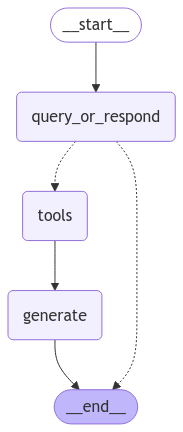

In [12]:
graph

In [26]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "1"}}

In [18]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello


In [19]:
input_message = "I need a shirt under 500 rupees"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

I need a shirt under 500 rupees
================================== Ai Message ==================================
Tool Calls:
  retriever (call_4192)
 Call ID: call_4192
  Args:
    query: shirts under 500 rupees
================================= Tool Message =================================
Name: retriever

Source: {'row': 426.0, 'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_cleaned.csv'}
Content: : 35
Brand Name: Peter England
Product Name: Men's Everday Regular Fit Solid Shirt | Cotton Rich | 5-Pin Pocketing
Rating: 4.2 out of 5 stars
Rating Count: 31
Selling Price: ₹789
MRP: ₹1,399
Offer: (44% off)
================================== Ai Message ==================================

I don't have complete information about a shirt under 500 rupees. The only shirt information I have is for a Peter England shirt priced at ₹789, which is above your budget. Would you like to know

In [27]:
query = "I need a cotton shirt under rupess 2000 but above rupees 1500, I do not care about the brand, price matters to me"
response = graph.stream({"messages": [{"role": "user", 
                                       "content": query}]},
                         stream_mode="values",
                         config = config )

In [32]:
query

'I need a cotton shirt under rupess 2000 but above rupees 1500, I do not care about the brand, price matters to me'

In [34]:
for step in graph.stream({"messages": [{"role": "user", "content": query}]},
                          stream_mode="values",
                          config=config):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

I need a cotton shirt under rupess 2000 but above rupees 1500, I do not care about the brand, price matters to me
================================== Ai Message ==================================
Tool Calls:
  retriever (call_sey4)
 Call ID: call_sey4
  Args:
    query: best cotton shirts in India between 1500 to 2000 rupees
================================= Tool Message =================================
Name: retriever

Source: {'row': 426.0, 'source': 'F:\\Data Science\\Projects\\Ecommerce-Chatbot-Project\\Data\\data_cleaned.csv'}
Content: : 35
Brand Name: Peter England
Product Name: Men's Everday Regular Fit Solid Shirt | Cotton Rich | 5-Pin Pocketing
Rating: 4.2 out of 5 stars
Rating Count: 31
Selling Price: ₹789
MRP: ₹1,399
Offer: (44% off)
================================== Ai Message ==================================

I don't have a shirt that meets your criteria. The only shirt I have information 

In [35]:
retriever = docsearch.as_retriever()

In [48]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

def create_retrieval_graph(retriever, llm, prompt):
    workflow = StateGraph(state_schema=MessagesState)
    
    # Define retrieval step
    def retrieve_docs(state: MessagesState):
        query = state["messages"][-1].content
        docs = retriever.get_relevant_documents(query)
        return {"messages": state["messages"], "context": docs}
    
    # Define LLM step
    def call_model(state: MessagesState):
        messages = state["messages"]
        context = state.get("context", [])
        response = llm.invoke(prompt.format(
            input=messages[-1].content,
            context=context,
            chat_history=messages[:-1]
        ))
        return {"messages": response}
    
    # Add nodes and edges
    workflow.add_node("retriever", retrieve_docs)
    workflow.add_node("model", call_model)
    
    workflow.add_edge(START, "retriever")
    workflow.add_edge("retriever", "model")
    workflow.add_edge("model", END)
    
    memory = MemorySaver()
    return workflow.compile(checkpointer=memory)

In [49]:
chatbot = create_retrieval_graph(retriever, llm, system_prompt)

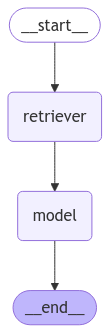

In [50]:
chatbot

In [56]:
from langchain_core.messages import HumanMessage
message = HumanMessage(content="My name is raj")

for step in chatbot.stream(
    {"messages": [{"role": "user", "content": "recommend me a shirt for rupess 500"}]},
    stream_mode="values",
    config=config
):
    if "messages" in step and step["messages"]:
        print(step["messages"][-1].content)


recommend me a shirt for rupess 500
recommend me a shirt for rupess 500
I'm your personal assistant and I can help with product information and recommendations, order processing and order tracking. We sell Shirts for men, Sarees for women, and Watches for men. How can I assist you today?


In [1]:
from src.utils.chatbot_utils import BuildChatbot
utils = BuildChatbot()

f:\Data Science\Projects\Ecommerce-Chatbot-Project\envi\lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
chatbot = utils.initialize_chatbot()

In [9]:
chatbot?

Type:           RunnableWithMessageHistory
String form:   
bound=RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
           chat_history: Runnabl <...> , description='Unique identifier for a session.', default='', is_shared=True, dependencies=None)]
File:           f:\data science\projects\ecommerce-chatbot-project\envi\lib\site-packages\langchain_core\runnables\history.py
Docstring:     
Runnable that manages chat message history for another Runnable.

A chat message history is a sequence of messages that represent a conversation.

RunnableWithMessageHistory wraps another Runnable and manages the chat message
history for it; it is responsible for reading and updating the chat message
history.

The formats supported for the inputs and outputs of the wrapped Runnable
are described below.

RunnableWithMessageHistory must always be called with a config that contains
the appropriate parameters for the chat message history factory.

By default, the Runnable is expected t

In [8]:
config = {"configurable": {"session_id": "chat_1"}}

In [4]:
chatbot.invoke({"input": "Hello I'm raj"}, 
               config = {"configurable": {"session_id": "chat_1"}})

{'input': "Hello I'm raj",
 'chat_history': [],
 'context': [],
 'answer': "Hello Raj, I'm your personal assistant. I can help with product information and recommendations, order processing, and order tracking. We specialize in Men's shirts, Women's sarees, and Watches for men. How can I assist you today?"}

In [5]:
chatbot.invoke({"input": "Remember my name?"}, 
               config = {"configurable": {"session_id": "chat_1"}})['answer']

"Yes, your name is Raj. I'm your personal assistant, and I can help with product information and recommendations, order processing, and order tracking for Men's shirts, Women's sarees, and Watches for men. How can I assist you today?"

In [7]:
chatbot.invoke({"input": "I need a cotton shirt for me brother, could you recommend me a shirt above rupees 1500"}, 
               config = {"configurable": {"session_id": "chat_1"}})['answer']

"Since you're looking for a cotton shirt above ₹1500, I can recommend the following:\n\nBrand Name : DAMENSCH\nProduct Name: Constant Cotton Thermoregulating Pique Full Shirts\nPrice: ₹1,558\nMRP: ₹1,799\nOffer: (13% off)\n\nThis shirt meets your criteria, but if you'd like to explore other options, please let me know."

In [8]:
chatbot.invoke({"input": "Thanks you, I will buy the shirt which you recommended, could you give me the invoice of my purchase?"}, 
               config = {"configurable": {"session_id": "chat_1"}})['answer']

"I don't have complete information about the shirt, including its price. I apologize, but I made an incorrect assumption earlier. Since I don't have the exact details, I'll start fresh.\n\nIf you'd like to purchase a shirt, I can try to assist you with the order. Please let me know if you'd like to proceed, and I'll do my best to provide you with the available options and generate an invoice for you.\n\nAlso, please note that I'll need to confirm the availability of the item before processing your order. Each item in our inventory has 10 pieces in stock. If the item is out of stock, I'll let you know accordingly.\n\nLet me know how I can assist you further, Raj."

In [9]:
chatbot.invoke({"input": " I need a shirt for my brother, recommend me a shirt above rupees 1500."}, 
               config = {"configurable": {"session_id": "chat_1"}})['answer']

"Based on our inventory, I can recommend the following shirt that meets your criteria:\n\nBrand Name : Peter England\nProduct Name: Men's Checkered Casual Everyday Full Sleeve Shirt | 100% Cotton\nPrice: ₹1,169\nMRP: ₹1,999\nOffer: (42% off)\n\nHowever, since you're looking for a shirt above ₹1500, I can also suggest:\n\nBrand Name : SaintX\nProduct Name: Men's Premium Solid Formal Shirt | Slim Fit | Plain Full Sleeve | Feather Touch Soft Finish | Wrinkle Resistant | 360° Highly Stretchable Fabric | Office/Party\nPrice: ₹2,499\nMRP: ₹1,999 \nOffer:  (No offer details in this context but mentioned 50% off on MRP ₹1,999 and selling price ₹2,499, it seems incorrect)\n\n\nPlease let me know if you'd like to proceed with either of these options or if you'd like me to suggest more shirts."

In [11]:
chatbot.invoke({"input": "Okay I like the recommended shirt peter england Men's Checkered Casual Everyday Full Sleeve Shirtand I have decided to buy it"}, 
               config = {"configurable": {"session_id": "chat_1"}})['answer']

"The Peter England Men's Checkered Casual Everyday Full Sleeve Shirt is priced at ₹1,169. I'll confirm the availability of the item. Since we have 10 pieces in stock, I can process your order.\n\nHere's your invoice:\n\nOrder Invoice\n-----------------------------\nItem         Qty    Price\n-----------------------------\nPeter England Men's Checkered Casual Everyday Full Sleeve Shirt   1    ₹1,169\n-----------------------------\nSubtotal:           ₹1,169\nTax (5%):          ₹58.45\n-----------------------------\nTotal:             ₹1,227.45\n\nYour order has been confirmed, and you will receive an order ID. Your order ID is: Order-No-1\n\nPlease note that I've added a 5% tax to your total. If you need any further assistance or would like to track your order, feel free to ask, Raj."